In [ ]:
#!pip uninstall -y qiskit qiskit-terra qiskit-aer qiskit-ibmq-provider qiskit-machine-learning qiskit-nature qiskit-finance qiskit-optimization


In [ ]:
!pip install --upgrade pip
!pip install "qiskit>=1.1.0" "qiskit-aer>=0.14.2" torch numpy matplotlib scipy


In [2]:
import qiskit
print("Qiskit version:", qiskit.__version__)


Qiskit version: 2.2.3


In [ ]:
!pip install mitiq

In [ ]:
!pip install numpy==1.26.4

In [4]:
!pip install 'qiskit-addon-utils'

In [1]:
# Cell 0: Imports & dependency check
import sys, os, math, time, copy, random
from dataclasses import dataclass
from typing import List, Tuple, Optional

import numpy as np
import matplotlib.pyplot as plt

# Import Qiskit + Aer;
HAS_QISKIT = False
HAS_AER = False
try:
    import qiskit
    from qiskit import QuantumCircuit, transpile
    from qiskit.providers.aer import AerSimulator
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.quantum_info import Statevector, Operator
    HAS_QISKIT = True
    try:
        # Attempt to instantiate AerSimulator to ensure qiskit-aer available
        _ = AerSimulator()
        HAS_AER = True
    except Exception:
        HAS_AER = False
except Exception:
    HAS_QISKIT = False
    HAS_AER = False

# PyTorch for PPO
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.distributions import Categorical
    HAS_TORCH = True
except Exception:
    HAS_TORCH = False

print("HAS_QISKIT:", HAS_QISKIT, "HAS_AER:", HAS_AER, "HAS_TORCH:", HAS_TORCH)
if not (HAS_QISKIT and HAS_AER):
    print("\nNOTE: Qiskit/Aer not fully available. Cells that need realistic noise models will fall back to toy simulator.")
if not HAS_TORCH:
    raise RuntimeError("PyTorch (torch) is required for the PPO implementation. Install with `pip install torch`.")


HAS_QISKIT: False HAS_AER: False HAS_TORCH: True

NOTE: Qiskit/Aer not fully available. Cells that need realistic noise models will fall back to toy simulator.


In [2]:
# Cell 1: Utility functions - extrapolators (linear, poly2, exponential)
import warnings


def linear_extrapolate(lambdas: List[float], values: List[float]) -> float:
    if len(lambdas) < 2:
        return values[0]
    A = np.vstack([lambdas, np.ones_like(lambdas)]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    a, b = sol[0], sol[1]
    return float(b)

def poly2_extrapolate(lambdas: List[float], values: List[float]) -> float:
    if len(lambdas) < 2:
        return values[0]
    A = np.vstack([np.array(lambdas)**2, np.array(lambdas), np.ones_like(lambdas)]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    return float(sol[2])

def exponential_extrapolate(lambdas: List[float], values: List[float]) -> float:
    lambdas = np.array(lambdas)
    values = np.array(values)
    minv = values.min()
    shift = 0.0
    if minv <= 0:
        shift = 1e-8 - minv
        values = values + shift
    if len(lambdas) == 1:
        return float(values[0] - shift)
    try:
        coefs = np.polyfit(lambdas, np.log(values), 1)
        c = -coefs[0]
        ln_b = coefs[1]
        b = math.exp(ln_b)
        return float(b - shift)
    except Exception:
        return float(values[0] - shift)

EXTRAPOLATORS = {
    0: ("linear", linear_extrapolate),
    1: ("poly2", poly2_extrapolate),
    2: ("exponential", exponential_extrapolate)
}


In [3]:
# Cell 2: Circuit generators - XYZ / TFIM Hamiltonian Trotterized circuits (Qiskit ≥1.0)
import numpy as np
from qiskit import QuantumCircuit
from qiskit.transpiler import CouplingMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter

def generate_xyz_hamiltonian_sparse(
    n_qubits: int,
    Jx: float = 0.4,
    Jy: float = 0.4,
    Jz: float = 0.0,
    hx: float = 0.0,
    hy: float = 0.0,
    hz: float = 0.6
) -> SparsePauliOp:
    """
    Build an XYZ (or TFIM) Hamiltonian in SparsePauliOp form.

    H = Σ_i [ Jx*X_i X_{i+1} + Jy*Y_i Y_{i+1} + Jz*Z_i Z_{i+1} ]
        + Σ_i [ hx*X_i + hy*Y_i + hz*Z_i ]
    with open boundary conditions.
    """
    terms = []
    coeffs = []

    # two-qubit couplings
    for i in range(n_qubits - 1):
        if abs(Jx) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "X"
            pauli[i + 1] = "X"
            terms.append("".join(pauli))
            coeffs.append(Jx)
        if abs(Jy) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "Y"
            pauli[i + 1] = "Y"
            terms.append("".join(pauli))
            coeffs.append(Jy)
        if abs(Jz) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "Z"
            pauli[i + 1] = "Z"
            terms.append("".join(pauli))
            coeffs.append(Jz)

    # single-qubit fields
    for i in range(n_qubits):
        if abs(hx) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "X"
            terms.append("".join(pauli))
            coeffs.append(hx)
        if abs(hy) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "Y"
            terms.append("".join(pauli))
            coeffs.append(hy)
        if abs(hz) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "Z"
            terms.append("".join(pauli))
            coeffs.append(hz)

    return SparsePauliOp.from_list(list(zip(terms, coeffs)))


def xyz_trotter_circuit(
    n_qubits: int = 4,
    trotter_steps: int = 2,
    dt: float = 0.1,
    Jx: float = 0.4,
    Jy: float = 0.4,
    Jz: float = 0.0,
    hx: float = 0.0,
    hy: float = 0.0,
    hz: float = 0.6,
    with_measure: bool = False
) -> QuantumCircuit:
    """
    Build a Trotterized time-evolution circuit for the XYZ / TFIM Hamiltonian
    using Qiskit 1.x `PauliEvolutionGate` (no deprecated opflow).

    Args:
        n_qubits: number of qubits.
        trotter_steps: number of Trotter repetitions.
        dt: time-step size.
        Jx, Jy, Jz: coupling strengths.
        hx, hy, hz: external field strengths.
        with_measure: whether to append measurements.
    """
    # Hamiltonian as SparsePauliOp
    H = generate_xyz_hamiltonian_sparse(n_qubits, Jx, Jy, Jz, hx, hy, hz)

    # Create the Trotter evolution gate using new synthesis interface
    evo_gate = PauliEvolutionGate(
        H,
        time=dt,
        synthesis=SuzukiTrotter(reps=1)  # single step per Trotter iteration
    )

    # Compose the evolution multiple times
    qc = QuantumCircuit(n_qubits)
    for _ in range(trotter_steps):
        qc.append(evo_gate, range(n_qubits))

    if with_measure:
        qc.measure_all()

    return qc


# --- Example test: small TFIM circuit ---
qc_test = xyz_trotter_circuit(n_qubits=3, trotter_steps=2, dt=0.1, Jx=0.5, hz=0.7, with_measure=True)
print(qc_test)


        ┌──────────────────────────────────────────────────────────┐»
   q_0: ┤0                                                         ├»
        │                                                          │»
   q_1: ┤1 exp(-it (XXI + YYI + IXX + IYY + ZII + IZI + IIZ))(0.1) ├»
        │                                                          │»
   q_2: ┤2                                                         ├»
        └──────────────────────────────────────────────────────────┘»
meas: 3/════════════════════════════════════════════════════════════»
                                                                    »
«        ┌──────────────────────────────────────────────────────────┐ ░ ┌─┐   »
«   q_0: ┤0                                                         ├─░─┤M├───»
«        │                                                          │ ░ └╥┘┌─┐»
«   q_1: ┤1 exp(-it (XXI + YYI + IXX + IYY + ZII + IZI + IIZ))(0.1) ├─░──╫─┤M├»
«        │                                        

In [4]:
# Cell 3: Circuit folding, mirrored, and Cliffordized utilities (Qiskit ≥1.0)
import math
import numpy as np

try:
    from qiskit import QuantumCircuit
    from qiskit.converters import circuit_to_dag, dag_to_circuit
    from qiskit.quantum_info import Clifford, SparsePauliOp
    HAS_QISKIT = True
except Exception:
    HAS_QISKIT = False


def fold_circuit(qc: "QuantumCircuit", lam: float) -> "QuantumCircuit":
    r"""
    Fold circuit to amplify noise.

    For a digital fold factor λ (e.g., 2.0), we repeat the unitary and its inverse
    to increase the number of gates, while preserving the logical function.

    Implementation:
      folded = U + (U U†) * (k-1) + optionally partial folding for fractional λ.

    Args:
        qc: Base QuantumCircuit.
        lam: Folding factor λ ≥ 1.
    """
    if not HAS_QISKIT:
        return {"folded_from": qc, "lam": lam}

    lam = float(lam)
    if lam <= 1.0:
        return qc.copy()

    k = int(math.floor(lam))
    frac = lam - k

    folded = qc.copy()
    # Integer folds: repeat U U† pairs
    for _ in range(max(0, k - 1)):
        folded = folded.compose(qc.inverse()).compose(qc)

    # Fractional folding
    if frac > 1e-8:
        dag = circuit_to_dag(qc)
        nodes = list(dag.topological_op_nodes())
        p = max(1, int(len(nodes) * frac))
        partial = QuantumCircuit(qc.num_qubits)
        for n in nodes[:p]:
            partial.append(n.op, n.qargs, n.cargs)
        folded = folded.compose(partial.inverse()).compose(partial)

    return folded


def mirror_circuit(qc: "QuantumCircuit") -> "QuantumCircuit":
    r"""
    Create a mirrored circuit: U followed by U†.

    This construction has a known ideal expectation (often +1 on certain observables),
    which makes it useful for calibration or benchmarking.

    Args:
        qc: Input circuit.
    """
    if not HAS_QISKIT:
        return {"mirrored_from": qc}

    mirrored = qc.copy()
    mirrored = mirrored.compose(qc.inverse())
    return mirrored


def cliffordize_circuit(qc: "QuantumCircuit") -> "QuantumCircuit":
    r"""
    Replace non-Clifford gates with approximate Clifford equivalents.

    This creates a circuit that can be simulated efficiently
    with stabilizer simulators. We approximate RX/RY/RZ gates
    whose angles are near multiples of π/2 as exact Clifford gates.

    Args:
        qc: Input QuantumCircuit.
    """
    if not HAS_QISKIT:
        return {"cliffordized_from": qc}

    new_qc = QuantumCircuit(qc.num_qubits)

    for instr, qargs, cargs in qc.data:
        name = instr.name.lower()
        if name in ("rx", "ry", "rz"):
            theta = float(instr.params[0])
            ratio = theta / (np.pi / 2)
            nearest = round(ratio)
            if abs(ratio - nearest) < 0.05:  # "close enough" to Clifford
                theta_cliff = nearest * (np.pi / 2)
                new_qc.append(instr.__class__(theta_cliff), qargs, cargs)
            else:
                new_qc.append(instr, qargs, cargs)
        else:
            new_qc.append(instr, qargs, cargs)

    return new_qc


In [5]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

folded_qc = fold_circuit(qc, 2.5)
mirrored_qc = mirror_circuit(qc)
cliff_qc = cliffordize_circuit(qc)

print("Folded circuit:")
print(folded_qc.draw())
print("\nMirrored circuit:")
print(mirrored_qc.draw())
print("\nCliffordized circuit:")
print(cliff_qc.draw())


Folded circuit:
     ┌───┐          ┌───┐┌───┐     ┌───┐┌───┐
q_0: ┤ H ├──■────■──┤ H ├┤ H ├──■──┤ H ├┤ H ├
     └───┘┌─┴─┐┌─┴─┐└───┘└───┘┌─┴─┐└───┘└───┘
q_1: ─────┤ X ├┤ X ├──────────┤ X ├──────────
          └───┘└───┘          └───┘          

Mirrored circuit:
     ┌───┐          ┌───┐
q_0: ┤ H ├──■────■──┤ H ├
     └───┘┌─┴─┐┌─┴─┐└───┘
q_1: ─────┤ X ├┤ X ├─────
          └───┘└───┘     

Cliffordized circuit:
     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘


/tmp/ipython-input-3347026808.py:90: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in qc.data:


In [ ]:
# import numpy as np
# import math
# import random
# from dataclasses import dataclass
# from typing import Optional, List, Dict
# HAS_QISKIT = False
# HAS_AER = False
# QC_CLASS = None
# StatevectorClass = None
# transpile = None
# NoiseModelClass = None
# AerSimulatorClass = None
# fold_circuit_func = None

# try:
#     import qiskit
#     from qiskit import QuantumCircuit
#     from qiskit import transpile as _transpile
#     from qiskit.quantum_info import Statevector
#     from qiskit.providers.aer import AerSimulator
#     from qiskit.providers.aer.noise import NoiseModel
#     # bind safely
#     HAS_QISKIT = True
#     try:
#         _ = AerSimulator()
#         HAS_AER = True
#     except Exception:
#         HAS_AER = False
#     QC_CLASS = QuantumCircuit
#     StatevectorClass = Statevector
#     transpile = _transpile
#     NoiseModelClass = NoiseModel
#     AerSimulatorClass = AerSimulator

#     # Fold & mirroring helpers
#     def fold_circuit(qc, lam: float):
#         """Lightweight folding using QC.copy() and concatenation.
#         if not isinstance(qc, QC_CLASS):
#             return qc
#         lam = float(lam)
#         k = int(math.floor(lam))
#         frac = lam - k
#         folded = qc.copy()
#         # append U U^\dagger pairs to increase gate count without changing logical op
#         for _ in range(max(0, k - 1)):
#             folded = folded + qc.inverse() + qc
#         if frac > 1e-8:
#             # append a small partial repetition using the first few operations
#             try:
#                 from qiskit.converters import circuit_to_dag
#                 dag = circuit_to_dag(qc)
#                 nodes = list(dag.topological_op_nodes())
#                 p = max(1, int(len(nodes) * frac))
#                 partial = QC_CLASS(qc.num_qubits)
#                 for n in nodes[:p]:
#                     partial.append(n.op, n.qargs, n.cargs)
#                 folded = folded + partial.inverse() + partial
#             except Exception:
#                 # fallback: duplicate entire qc once
#                 folded = folded + qc.inverse() + qc
#         return folded

#     fold_circuit_func = fold_circuit

# except Exception:
#     # Qiskit not available — prepare placeholders
#     HAS_QISKIT = False
#     HAS_AER = False
#     QC_CLASS = None
#     StatevectorClass = None
#     transpile = lambda qc, **kwargs: qc
#     NoiseModelClass = None
#     AerSimulatorClass = None

#     : keeps descriptor as-is
#     def fold_circuit_placeholder(qc, lam: float):
#         return {"folded_from": qc, "lam": lam}
#     fold_circuit_func = fold_circuit_placeholder

# # ---------------------------
# # Extrapolators (small set)
# # ---------------------------
# def linear_extrapolate(lambdas: List[float], values: List[float]) -> float:
#     if len(lambdas) < 2:
#         return float(values[0])
#     A = np.vstack([lambdas, np.ones_like(lambdas)]).T
#     sol, *_ = np.linalg.lstsq(A, values, rcond=None)
#     a, b = sol[0], sol[1]
#     return float(b)

# def poly2_extrapolate(lambdas: List[float], values: List[float]) -> float:
#     if len(lambdas) < 2:
#         return float(values[0])
#     A = np.vstack([np.array(lambdas)**2, np.array(lambdas), np.ones_like(lambdas)]).T
#     sol, *_ = np.linalg.lstsq(A, values, rcond=None)
#     return float(sol[2])

# def exponential_extrapolate(lambdas: List[float], values: List[float]) -> float:
#     lambdas = np.array(lambdas)
#     values = np.array(values, dtype=float)
#     minv = values.min()
#     shift = 0.0
#     if minv <= 0:
#         shift = 1e-8 - minv
#         values = values + shift
#     if len(lambdas) == 1:
#         return float(values[0] - shift)
#     try:
#         coefs = np.polyfit(lambdas, np.log(values), 1)
#         ln_b = coefs[1]
#         b = math.exp(ln_b)
#         return float(b - shift)
#     except Exception:
#         return float(values[0] - shift)

# EXTRAPOLATORS = {
#     0: ("linear", linear_extrapolate),
#     1: ("poly2", poly2_extrapolate),
#     2: ("exponential", exponential_extrapolate)
# }

# # ---------------------------
# # Data classes
# # ---------------------------
# @dataclass
# class HardwareProfile:
#     name: str
#     t1: float
#     two_q_time: float
#     base_error: float

# @dataclass
# class CircuitFeatures:
#     n_qubits: int
#     two_q_count: int
#     two_q_depth: int
#     trotter_steps: int

# # ---------------------------
# # ---------------------------
# class ZNEEnvQiskit:
#     def __init__(self,
#                  qc_or_desc,
#                  hw: HardwareProfile,
#                  pool: Optional[List[float]] = None,
#                  max_folds: int = 4,
#                  alpha: float = 0.1,
#                  shots: int = 2048):
#         self.has_qiskit = HAS_QISKIT and HAS_AER
#         self.qc_desc = qc_or_desc
#         self.hw = hw
#         self.alpha = alpha
#         self.max_folds = max_folds
#         self.shots = shots
#         if pool is None:
#             pool = [1.0, 1.2, 1.5, 2.0, 3.0]
#         self.pool = self._prescreen(pool)
#         self.E = len(EXTRAPOLATORS)
#         self.ACTIONS_PER_STEP = len(self.pool) + 1  # pool choices + STOP
#         self.extrap_idx = None
#         self.selected = []
#         self.done = False
#         self.ideal = 0.0
#         # reset will compute ideal
#         self.reset()

#     def _prescreen(self, pool: List[float]) -> List[float]:
#         # If no Qiskit, use descriptor fallback using a simple depth estimate
#         try:
#             if HAS_QISKIT and (QC_CLASS is not None) and isinstance(self.qc_desc, QC_CLASS):
#                 # try to get depth via transpile
#                 t_qc = transpile(self.qc_desc, optimization_level=0)
#                 depth = getattr(t_qc, "depth", lambda: 1)()
#             elif isinstance(self.qc_desc, dict):
#                 depth = self.qc_desc.get("steps", 1) * max(1, self.qc_desc.get("n", 4))
#             else:
#                 depth = 1
#         except Exception:
#             depth = 1
#         f = 0.9
#         res = [lam for lam in pool if lam * depth * self.hw.two_q_time <= f * self.hw.t1]
#         if 1.0 not in res:
#             res = [1.0] + res
#         return sorted(set(res))

#     def reset(self):
#         # reset internal state; compute ideal expectation if possible
#         self.extrap_idx = None
#         self.selected = []
#         self.done = False
#         # compute ideal expectation
#         try:
#             if HAS_QISKIT and (QC_CLASS is not None) and isinstance(self.qc_desc, QC_CLASS):
#                 # remove measurements safely (if present)
#                 try:
#                     qc_nom = self.qc_desc.remove_final_measurements(inplace=False)
#                 except Exception:
#                     qc_nom = self.qc_desc
#                 # Compute statevector and expectation of Z on qubit 0
#                 try:
#                     sv = StatevectorClass.from_instruction(qc_nom)
#                     probs = np.abs(sv.data) ** 2
#                     expect = 0.0
#                     for idx, p in enumerate(probs):
#                         b0 = (idx >> 0) & 1
#                         expect += ((-1) ** b0) * p
#                     self.ideal = float(expect)
#                 except Exception:
#                     # fallback analytic if statevector failed
#                     self.ideal = self._analytic_ideal_from_desc()
#             else:
#                 self.ideal = self._analytic_ideal_from_desc()
#         except Exception:
#             self.ideal = self._analytic_ideal_from_desc()
#         return self._observation()

#     def _analytic_ideal_from_desc(self):
#         # rough analytic ideal for descriptor circuits
#         if isinstance(self.qc_desc, dict):
#             n = self.qc_desc.get("n", 4)
#             steps = self.qc_desc.get("steps", 1)
#             energy = 1.0 + 0.1 * (n - 4)
#             t = max(0.1, 0.5 * steps)
#             return float(max(-1.0, min(1.0, math.cos(energy * t))))
#         return 0.0

#     def _compute_observable_expectation(self, sv, n_qubits: int):
#         probs = np.abs(sv.data) ** 2
#         expect = 0.0
#         for idx, p in enumerate(probs):
#             b0 = (idx >> 0) & 1
#             expect += ((-1) ** b0) * p
#         return float(expect)

#     def _simulate_qiskit_noisy(self, qc, lam: float) -> float:
#         # If Qiskit/Aer not available, use analytic decay model
#         if not (HAS_QISKIT and HAS_AER and (QC_CLASS is not None)):
#             decay = self.hw.base_error * (1.0 + 0.01 * len(self.selected)) * lam
#             noisy = self.ideal * math.exp(-decay) + np.random.normal(scale=0.01)
#             return float(max(-1.0, min(1.0, noisy)))

#         # If qc is a descriptor but not a real QuantumCircuit, fall back to analytic
#         if not isinstance(self.qc_desc, QC_CLASS):
#             decay = self.hw.base_error * lam
#             noisy = self.ideal * math.exp(-decay) + np.random.normal(scale=0.01)
#             return float(max(-1.0, min(1.0, noisy)))

#         # Build folded circuit via helper
#         folded = fold_circuit_func(self.qc_desc, lam)

#         # Build a lightweight noise model; if unavailable, run noiseless density-matrix sim and add analytic noise
#         try:
#             noise = NoiseModelClass()
#             sim = AerSimulatorClass(method='density_matrix')
#             t_qc = transpile(folded, sim)
#             job = sim.run(t_qc, noise_model=noise, shots=self.shots)
#             res = job.result()
#             counts = res.get_counts()
#             mean = 0.0
#             total = sum(counts.values()) if counts else 1
#             for bitstr, c in counts.items():
#                 b0 = int(bitstr[-1])
#                 mean += ((-1) ** b0) * (c / total)
#             return float(mean)
#         except Exception:
#             # fallback analytic if Aer/NoiseModel call fails
#             decay = self.hw.base_error * lam
#             noisy = self.ideal * math.exp(-decay) + np.random.normal(scale=0.01)
#             return float(max(-1.0, min(1.0, noisy)))

#     def _run_zne(self, extrap_idx: int, lambdas: List[float]):
#         vals = [self._simulate_qiskit_noisy(self.qc_desc if (HAS_QISKIT and isinstance(self.qc_desc, QC_CLASS)) else None, l) for l in lambdas]
#         est = EXTRAPOLATORS[extrap_idx][1](lambdas, vals)
#         return est, vals

#     def _observation(self):
#         # create a compact feature vector
#         if isinstance(self.qc_desc, dict):
#             n = self.qc_desc.get("n", 4)
#             steps = self.qc_desc.get("steps", 1)
#             depth = int(n * steps)
#         else:
#             try:
#                 depth = getattr(self.qc_desc, "depth", lambda: 1)()
#                 n = getattr(self.qc_desc, "num_qubits", 4)
#                 steps = max(1, depth // max(1, n))
#             except Exception:
#                 depth = 1; n = 4; steps = 1
#         fv = [
#             float(n), float(depth), float(steps),
#             float(self.hw.t1), float(self.hw.two_q_time), float(self.hw.base_error),
#             float(len(self.selected)), float(sum(self.selected) if self.selected else 0.0)
#         ]
#         pool_pad = list(_


In [6]:
# Robust Mitiq ZNE helper functions (execute_with_zne + decorators)
from typing import Callable, Sequence, List, Optional, Union
from collections.abc import Iterable
import math

from mitiq import QPROGRAM, Executor as MitiqExecutor, Observable, QuantumResult
from mitiq.zne.inference import Factory, RichardsonFactory
from mitiq.zne.scaling import fold_gates_at_random

# --- construct_circuits (keeps original semantics) ---
def construct_circuits(
    circuit: QPROGRAM,
    scale_factors: Sequence[float],
    scale_method: Callable[[QPROGRAM, float], QPROGRAM] = fold_gates_at_random,  # type: ignore[has-type]
) -> List[QPROGRAM]:
    """Given a circuit and scale_factors, returns scaled circuits using scale_method."""
    if not isinstance(scale_factors, Iterable):
        raise TypeError("scale_factors must be an iterable of floats.")
    circuits = [scale_method(circuit, float(sf)) for sf in scale_factors]
    return circuits


# --- combine_results (thin wrapper around chosen extrapolation callable) ---
def combine_results(
    scale_factors: Sequence[float],
    results: Sequence[float],
    extrapolation_method: Callable[[Sequence[float], Sequence[float]], float],
) -> float:
    """Apply an extrapolation method (callable) to produce the final ZNE estimate."""
    if len(scale_factors) != len(results):
        raise ValueError("scale_factors and results must have the same length.")
    return float(extrapolation_method(scale_factors, results))


# --- helper: call executor in a robust way ---
def _call_executor_single(
    executor: Union[Callable[[QPROGRAM], QuantumResult], MitiqExecutor],
    circuit: QPROGRAM,
) -> QuantumResult:
    """
    Best-effort wrapper that calls 'executor' on a single circuit and returns a QuantumResult-like object
    or numeric expectation. Supports plain callables and Mitiq Executor-like wrappers.
    """
    # If user passed an actual mitiq.Executor instance, prefer its 'execute' or 'run' if available.
    try:
        # If executor is a MitiqExecutor object, try methods commonly exposed
        if isinstance(executor, MitiqExecutor):
            # try batch execution first if it supports it
            if getattr(executor, "can_batch", False):
                # some Executor implementations offer .execute(circ) or .run(circ) — try both
                if hasattr(executor, "execute"):
                    return executor.execute(circuit)
                elif hasattr(executor, "run"):
                    return executor.run([circuit])
                else:
                    # fallback to calling as callable
                    return executor(circuit)
            else:
                # not batch-capable: try execute or call directly
                if hasattr(executor, "execute"):
                    return executor.execute(circuit)
                else:
                    return executor(circuit)
    except Exception:
        # If the above path fails, fall through to treating executor as simple callable.
        pass

    # Finally, attempt to call executor as a plain callable
    result = executor(circuit)
    return result


# --- main function: execute_with_zne ---
def execute_with_zne(
    circuit: QPROGRAM,
    executor: Union[Callable[[QPROGRAM], Union[QuantumResult, float]], MitiqExecutor],
    observable: Optional[Observable] = None,
    *,
    factory: Optional[Factory] = None,
    scale_noise: Callable[[QPROGRAM, float], QPROGRAM] = fold_gates_at_random,  # type: ignore[has-type]
    num_to_average: int = 1,
) -> float:
    """
    Estimate the error-mitigated expectation value for `circuit` using ZNE.

    Args:
        circuit: input circuit (QPROGRAM).
        executor: a callable that accepts a circuit and returns either:
                  - a numeric expectation (float), or
                  - a QuantumResult-like object (object with numeric .value/.values or convertible to float).
                  Alternatively, a mitiq.Executor instance may be supplied (best-effort support).
        observable: optional Observable — if provided, the executor's QuantumResult is used to compute
                    the observable expectation. If None, the executor must already return an expectation.
        factory: a mitiq Factory (e.g. RichardsonFactory, PolyFactory). If None, defaults to RichardsonFactory([1,2,3]).
        scale_noise: a function (circuit, scale_factor) -> scaled circuit (e.g. fold_gates_at_random).
        num_to_average: times to run each scaled circuit and average the returned expectation.

    Returns:
        float: the error-mitigated expectation.
    """
    # Validate inputs
    if num_to_average < 1:
        raise ValueError("num_to_average must be >= 1.")
    if not callable(scale_noise):
        raise TypeError("scale_noise must be callable.")

    # Default factory
    if factory is None:
        factory = RichardsonFactory(scale_factors=[1.0, 2.0, 3.0])

    if not isinstance(factory, Factory):
        raise TypeError("factory must be an instance of mitiq.zne.inference.Factory (or subclass).")

    # Determine scale factors to use:
    # Prefer factory.scale_factors if present; else try attribute names used by specific factories.
    scale_factors = None
    if hasattr(factory, "scale_factors"):
        scale_factors = getattr(factory, "scale_factors")
    elif hasattr(factory, "_scale_factors"):
        scale_factors = getattr(factory, "_scale_factors")
    # Always ensure we have a list
    if scale_factors is None:
        # fallback to the common default
        scale_factors = [1.0, 2.0, 3.0]
    scale_factors = list(map(float, scale_factors))
    if len(scale_factors) < 1:
        raise ValueError("factory must provide at least one scale factor.")

    # Build scaled circuits using provided scale_noise function
    scaled_circuits = construct_circuits(circuit, scale_factors, scale_noise)

    # Execute each scaled circuit (with averaging) and extract expectation values
    results: List[float] = []
    for idx, scaled in enumerate(scaled_circuits):
        vals_for_scale = []
        for _ in range(num_to_average):
            raw = _call_executor_single(executor, scaled)

            # interpret the returned raw object:
            # - If it's numeric (float or numpy scalar), accept it
            # - If it's a QuantumResult-like object, try to extract a numeric value:
            #     * If has attribute 'value' or 'values', use it.
            #     * If it's a dict-like (quasi-distribution), attempt to compute expectation of Z on qubit 0 if observable is None.
            val = None
            # numeric case
            if isinstance(raw, (int, float)):
                val = float(raw)
            else:
                # try common QuantumResult patterns
                # prefer .value / .values
                if hasattr(raw, "value"):
                    try:
                        val = float(raw.value)
                    except Exception:
                        # if it's iterable, take first element
                        try:
                            val = float(raw.value[0])
                        except Exception:
                            val = None
                elif hasattr(raw, "values"):
                    try:
                        v = raw.values
                        # conversion for numpy arrays
                        if hasattr(v, "__len__") and len(v) > 0:
                            val = float(v[0])
                        else:
                            val = float(v)
                    except Exception:
                        val = None
                elif isinstance(raw, dict):
                    # quasi-probability dict {bitstr: prob}. If observable given, we cannot easily evaluate here,
                    # so try Z on lsb (qubit 0) expectation as fallback.
                    if observable is None:
                        total = 0.0
                        totp = 0.0
                        for bitstr, p in raw.items():
                            try:
                                b0 = int(bitstr[-1])
                            except Exception:
                                # if bitstr is int key
                                b0 = int(bitstr) & 1
                            total += ((-1) ** b0) * float(p)
                            totp += float(p)
                        if totp > 0:
                            val = float(total / totp)
                        else:
                            val = 0.0
                # last fallback: try to convert the raw object to float directly
                if val is None:
                    try:
                        val = float(raw)
                    except Exception:
                        raise RuntimeError(
                            "Executor returned an unsupported result type; expected numeric or QuantumResult-like."
                        )

            vals_for_scale.append(float(val))

        # average for this scale factor
        avg_val = float(sum(vals_for_scale) / float(len(vals_for_scale)))
        results.append(avg_val)

    # Use the factory to produce the extrapolated estimate.
    # Prefer factory.run(...) if available (it handles bookkeeping), otherwise emulate minimal contract:
    try:
        # if factory.run exists and returns a Factory-like run result, use that (safer for complex factories)
        if hasattr(factory, "run"):
            # many factory.run implementations expect: (circuit, executor, observable, scale_noise, num_to_average)
            # but we already executed ourselves; some factories accept 'instack'/'outstack' directly: try to use reduce if possible.
            # We'll attempt a minimal-compatible approach: set internal stacks and call reduce()
            try:
                # some Factory implementations expose instack/outstack attributes
                if hasattr(factory, "_instack") and hasattr(factory, "_outstack"):
                    # set instack/outstack using scale_factors and results
                    factory._instack = [{"scale_factor": float(sf)} for sf in scale_factors]
                    factory._outstack = list(results)
                    est = float(factory.reduce())
                    return est
            except Exception:
                # Fall through to call factory.run as a last resort (but factory.run expects an executor to run circuits)
                pass

        # If we get here, fallback to using the provided callable extrapolation if the factory exposes 'reduce' only
        if hasattr(factory, "reduce"):
            # set internal stacks if possible then reduce
            if hasattr(factory, "_instack") and hasattr(factory, "_outstack"):
                factory._instack = [{"scale_factor": float(sf)} for sf in scale_factors]
                factory._outstack = list(results)
                est = float(factory.reduce())
                return est
    except Exception:
        # if factory internals are inaccessible, proceed to classical extrapolation fallback
        pass

    # Last-resort: try to use a small set of built-in extrapolators heuristically:
    # for compatibility with the rest of your code, try to detect common factory types
    # If factory is RichardsonFactory, perform simple Richardson extrapolation (polynomial fit with degree len-1)
    try:
        from mitiq.zne.inference import RichardsonFactory as _RF

        if isinstance(factory, _RF):
            # classical Richardson: fit polynomial in scale and evaluate at scale=0
            coefs = np.polyfit(scale_factors, results, deg=min(len(scale_factors) - 1, 3))
            # evaluate polynomial at 0 -> constant term is last coefficient in np.polyfit order
            est = float(np.polyval(coefs, 0.0))
            return est
    except Exception:
        pass

    # If all else fails, use simple linear extrapolation (fit ax + b and return b)
    coefs = np.polyfit(scale_factors, results, 1)
    est = float(np.polyval(coefs, 0.0))
    return est


# --- mitigate_executor wrapper that returns a callable executor performing ZNE ---
def mitigate_executor(
    executor: Callable[[QPROGRAM], QuantumResult],
    observable: Optional[Observable] = None,
    *,
    factory: Optional[Factory] = None,
    scale_noise: Callable[[QPROGRAM, float], QPROGRAM] = fold_gates_at_random,  # type: ignore[has-type]
    num_to_average: int = 1,
) -> Callable[[QPROGRAM], float]:
    """
    Wrap an executor function so that calling the returned function runs execute_with_zne.
    If the input executor is batch-capable, the returned function will still perform per-circuit ZNE.
    """
    # Best-effort wrap (support for mitiq.Executor instances or plain callables)
    executor_obj = None
    try:
        # If user passed a Mitiq Executor instance, use as-is
        if isinstance(executor, MitiqExecutor):
            executor_obj = executor
        else:
            # otherwise wrap the callable in the mitiq.Executor helper if available
            executor_obj = MitiqExecutor(executor) if hasattr(MitiqExecutor, "__call__") or True else executor
    except Exception:
        executor_obj = executor

    # returned function handles both single circuit and list (if executor_obj supports batching it will be used internally)
    def new_executor(circ_or_circuits):
        # If the executor is a callable and input is list, we iterate calling execute_with_zne for each circuit.
        if isinstance(circ_or_circuits, (list, tuple)):
            outputs = []
            for c in circ_or_circuits:
                outputs.append(
                    execute_with_zne(
                        c,
                        executor_obj,
                        observable,
                        factory=factory,
                        scale_noise=scale_noise,
                        num_to_average=num_to_average,
                    )
                )
            return outputs
        else:
            return execute_with_zne(
                circ_or_circuits,
                executor_obj,
                observable,
                factory=factory,
                scale_noise=scale_noise,
                num_to_average=num_to_average,
            )

    return new_executor


# --- zne_decorator: convenient decorator to wrap executors ---
def zne_decorator(
    observable: Optional[Observable] = None,
    *,
    factory: Optional[Factory] = None,
    scale_noise: Callable[[QPROGRAM, float], QPROGRAM] = fold_gates_at_random,  # type: ignore[has-type]
    num_to_average: int = 1,
) -> Callable[[Callable[[QPROGRAM], QuantumResult]], Callable[[QPROGRAM], float]]:
    """
    Return decorator which wraps an executor function to call ZNE when executed.
    Usage:
        @zne_decorator()
        def my_executor(circuit):
            ... return QuantumResult or float ...
    """
    # If used without parentheses, disallow by checking callable observable
    if callable(observable):
        raise TypeError("zne_decorator must be used with parentheses, e.g. @zne_decorator()")

    def decorator(exec_fn: Callable[[QPROGRAM], QuantumResult]) -> Callable[[QPROGRAM], float]:
        return mitigate_executor(exec_fn, observable, factory=factory, scale_noise=scale_noise, num_to_average=num_to_average)

    return decorator


In [12]:
# RL environment using Mitiq for ZNE
import numpy as np
import math
import random
from dataclasses import dataclass
from typing import Optional, List, Dict, Any


# Import Mitiq and configure backends
try:
    import qiskit
    from qiskit import QuantumCircuit
    from qiskit.quantum_info import Statevector
    HAS_QISKIT = True
except Exception:
    HAS_QISKIT = False
    QuantumCircuit = None
    Statevector = None

try:
    from mitiq import zne
    from mitiq.zne.scaling import fold_gates_at_random
    from mitiq.zne.inference import RichardsonFactory, PolyFactory
    HAS_MITIQ = True
except Exception:
    HAS_MITIQ = False

# ----------------------------------------------------------
# Data Classes
# ----------------------------------------------------------
@dataclass
class HardwareProfile:
    name: str
    t1: float
    two_q_time: float
    base_error: float


# ----------------------------------------------------------
# Mitiq-based ZNE Environment
# ----------------------------------------------------------
class ZNEEnvMitiq:
    """
    RL Environment for Zero-Noise Extrapolation parameter selection using Mitiq.
    """
    def __init__(
        self,
        qc_or_desc,
        hw: HardwareProfile,
        pool: Optional[List[float]] = None,
        max_folds: int = 4,
        alpha: float = 0.1,
        shots: int = 1024,
    ):
        self.qc = qc_or_desc
        self.hw = hw
        self.alpha = alpha
        self.max_folds = max_folds
        self.shots = shots

        self.pool = pool or [1.0, 1.5, 2.0, 3.0]
        self.E = 2  # 0: Richardson, 1: Polynomial (deg=2)
        self.ACTIONS_PER_STEP = len(self.pool) + 1
        self.done = False
        self.selected = []
        self.extrap_idx = None
        self.ideal = 0.0
        self.reset()

    # ------------------------------------------------------
    # Observation generation
    # ------------------------------------------------------
    def _observation(self):
        n = getattr(self.qc, "num_qubits", 4) if HAS_QISKIT else 4
        depth = getattr(self.qc, "depth", lambda: 1)() if HAS_QISKIT else 1
        return np.array(
            [
                float(n),
                float(depth),
                self.hw.t1,
                self.hw.two_q_time,
                self.hw.base_error,
                len(self.selected),
                sum(self.selected) if self.selected else 0.0,
            ],
            dtype=np.float32,
        )

    # ------------------------------------------------------
    # Reset
    # ------------------------------------------------------
    def reset(self):
        self.done = False
        self.selected = []
        self.extrap_idx = None
        self.ideal = self._compute_ideal()
        return self._observation()

    def _compute_ideal(self) -> float:
        """Compute ideal expectation ."""
        if HAS_QISKIT and isinstance(self.qc, QuantumCircuit):
            try:
                sv = Statevector.from_instruction(self.qc)
                probs = np.abs(sv.data) ** 2
                expect = 0.0
                for idx, p in enumerate(probs):
                    bit0 = (idx >> 0) & 1
                    expect += ((-1) ** bit0) * p
                return float(expect)
            except Exception:
                pass
        # Analytic fallback
        return math.cos(0.2 * random.random())

    # ------------------------------------------------------
    # Noise simulation
    # ------------------------------------------------------
    def _simulate_noisy(self, lam: float) -> float:
        """Analytic model: exponential decay in lam."""
        decay = self.hw.base_error * lam
        noisy = self.ideal * math.exp(-decay) + np.random.normal(0, 0.02)
        return max(-1.0, min(1.0, noisy))

    # ------------------------------------------------------
    # Mitiq extrapolation run
    # ------------------------------------------------------
    def _run_zne(self, extrap_idx: int, lambdas: List[float]):
        """Use Mitiq factories for extrapolation."""
        vals = [self._simulate_noisy(l) for l in lambdas]
        if not HAS_MITIQ:
            est = np.polyfit(lambdas, vals, 1)[1]  # fallback linear
            return est, vals

        # Choose factory
        if extrap_idx == 0:
            factory = RichardsonFactory(scale_factors=lambdas)
        else:
            factory = PolyFactory(scale_factors=lambdas, order=min(2, len(lambdas) - 1))

        # Classical run using provided data
        factory._instack = [{"scale_factor": l} for l in lambdas]
        factory._outstack = vals
        est = factory.reduce()
        return est, vals

    # ------------------------------------------------------
    # Step
    # ------------------------------------------------------
    def step(self, action: int):
        if self.done:
            raise RuntimeError("Episode already finished. Reset environment.")
        # Step 1: choose extrapolator
        if self.extrap_idx is None:
            if action not in [0, 1]:
                raise ValueError("Invalid extrapolator choice")
            self.extrap_idx = int(action)
            return self._observation(), 0.0, False, {}

        # Step 2: choose lambda or stop
        if action == self.ACTIONS_PER_STEP - 1:
            # Stop and compute ZNE
            lambdas = self.selected or [1.0]
            est, vals = self._run_zne(self.extrap_idx, lambdas)
            mse = (est - self.ideal) ** 2
            cost = self.alpha * len(lambdas)
            reward = -mse - cost
            self.done = True
            return (
                self._observation(),
                float(reward),
                True,
                {"est": est, "ideal": self.ideal, "lambdas": lambdas, "vals": vals},
            )
        else:
            lam = float(self.pool[action])
            if len(self.selected) < self.max_folds:
                self.selected.append(lam)
            return self._observation(), 0.0, False, {}


# ----------------------------------------------------------
# Small test
# ----------------------------------------------------------
if __name__ == "__main__":
    hw = HardwareProfile(name="sim", t1=100.0, two_q_time=1.0, base_error=0.01)

    if HAS_QISKIT:
        qc = QuantumCircuit(2)
        qc.h(0)
        qc.cx(0, 1)
    else:
        qc = {"n": 4, "steps": 2}

    env = ZNEEnvMitiq(qc, hw)
    obs = env.reset()
    print("Initial observation:", obs)

    # Choose Richardson extrapolation
    obs, r, done, info = env.step(0)
    # Choose two folds and stop
    obs, r, done, info = env.step(1)
    obs, r, done, info = env.step(2)
    obs, r, done, info = env.step(env.ACTIONS_PER_STEP - 1)
    print("Result:", info)

Initial observation: [2.e+00 2.e+00 1.e+02 1.e+00 1.e-02 0.e+00 0.e+00]
Result: {'est': np.float64(-0.05757762884358066), 'ideal': 0.0, 'lambdas': [1.5, 2.0], 'vals': [-0.031088819373481145, -0.022259216216781296]}


In [7]:
#PPO Agent (PyTorch) - hierarchical policy for extrapolator + fold sequence

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Actor-Critic Neural Network

class ActorCritic(nn.Module):
    """
    Shared actor-critic network for PPO.
    - Shared feature extractor
    - Separate heads for value and action logits
    - Supports variable action dimensions via dynamic head creation
    """
    def __init__(self, obs_dim, hidden=128):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU()
        )
        self.value_head = nn.Linear(hidden, 1)
        self.action_heads = {}  # dictionary: action_dim -> nn.Linear(hidden, action_dim)
        self.hidden_dim = hidden

    def forward_shared(self, obs: torch.Tensor):
        return self.shared(obs)

    def get_value(self, feat: torch.Tensor):
        return self.value_head(feat).squeeze(-1)

    def get_action_logits(self, feat: torch.Tensor, action_dim: int):
        if action_dim not in self.action_heads:
            # Lazy creation of head per unique action dimension
            self.action_heads[action_dim] = nn.Linear(self.hidden_dim, action_dim).to(device)
        logits = self.action_heads[action_dim](feat)
        return logits



# PPO Agent

class PPOAgent:
    def __init__(self, obs_dim, lr=3e-4, clip=0.2, epochs=4, gamma=0.99, lam=0.95):
        self.net = ActorCritic(obs_dim).to(device)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
        self.clip = clip
        self.epochs = epochs
        self.gamma = gamma
        self.lam = lam


    # Select action using current policy
    #
    def select_action(self, obs_np, action_dim):
        obs = torch.tensor(obs_np, dtype=torch.float32, device=device).unsqueeze(0)
        feat = self.net.forward_shared(obs)
        logits = self.net.get_action_logits(feat, action_dim)
        probs = torch.softmax(logits, dim=-1)
        dist = Categorical(probs)
        action = dist.sample()
        logp = dist.log_prob(action)
        entropy = dist.entropy()
        return (
            int(action.item()),
            logp.detach(),
            entropy.detach(),
            probs.detach().cpu().numpy().ravel(),
            feat.detach().cpu().numpy().ravel()
        )


    # Compute Generalized Advantage Estimate (GAE)
    #
    def compute_gae(self, rewards, masks, values):
        # rewards: list, masks: list(0 if done else 1), values: list
        values = values + [0.0]
        gae = 0.0
        returns = []
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + self.gamma * values[step+1] * masks[step] - values[step]
            gae = delta + self.gamma * self.lam * masks[step] * gae
            returns.insert(0, gae + values[step])
        return returns

    # ------------------------------------------------------------
    # PPO Update
    # ------------------------------------------------------------
    def update(self, trajectories):
        """
        trajectories: list of dicts with keys
        ['obs', 'action', 'logp', 'ret', 'value', 'action_dim']
        """

        # Convert lists to detached tensors
        obs = torch.tensor(np.vstack([t['obs'] for t in trajectories]), dtype=torch.float32, device=device)
        actions = torch.tensor([t['action'] for t in trajectories], dtype=torch.long, device=device)
        old_logps = torch.tensor([float(t['logp']) for t in trajectories], dtype=torch.float32, device=device).detach()
        returns = torch.tensor([float(t['ret']) for t in trajectories], dtype=torch.float32, device=device).detach()
        old_values = torch.tensor([float(t['value']) for t in trajectories], dtype=torch.float32, device=device).detach()

        # Advantage (A = R - V)
        advantages = (returns - old_values).detach()
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # ------------------------------------------------------------
        # Multiple PPO epochs (each uses a new forward pass)
        # ------------------------------------------------------------
        for _ in range(self.epochs):
            feat = self.net.forward_shared(obs)  # fresh computation graph each epoch
            action_dims = list(set([t['action_dim'] for t in trajectories]))

            total_policy_loss = 0.0
            total_value_loss = 0.0
            group_count = 0

            for ad in action_dims:
                # indices for this action dimension
                idxs = [i for i, t in enumerate(trajectories) if t['action_dim'] == ad]
                if not idxs:
                    continue
                idxs_t = torch.tensor(idxs, dtype=torch.long, device=device)

                feat_sub = feat[idxs_t]
                logits = self.net.get_action_logits(feat_sub, ad)
                dist = Categorical(logits=logits)
                new_logp = dist.log_prob(actions[idxs_t])

                ratio = torch.exp(new_logp - old_logps[idxs_t])
                surr1 = ratio * advantages[idxs_t]
                surr2 = torch.clamp(ratio, 1.0 - self.clip, 1.0 + self.clip) * advantages[idxs_t]
                policy_loss = -torch.min(surr1, surr2).mean()

                value_pred = self.net.get_value(feat_sub)
                value_loss = 0.5 * (returns[idxs_t] - value_pred).pow(2).mean()

                total_policy_loss += policy_loss
                total_value_loss += value_loss
                group_count += 1

            if group_count == 0:
                continue

            total_policy_loss /= float(group_count)
            total_value_loss /= float(group_count)

            loss = total_policy_loss + total_value_loss

            # Backprop once per epoch
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return float(loss.item())


In [10]:
# Training loop tying environment and PPO agent
import numpy as np
import random
import torch

# - ---
try:
    tfim_trotter_circuit  # noqa: F821
except NameError:
    # create alias so legacy calls work
    tfim_trotter_circuit = xyz_trotter_circuit

# Training loop (PPO) - adapted to ZNEEnvMitiq
def run_training(env_gen, episodes=200, max_steps=6, eval_every=50):
    """
    env_gen: callable that returns a fresh env instance (ZNEEnvMitiq)
    episodes: number of training episodes
    max_steps: max fold-selection steps after extrapolator
    eval_every: print progress every eval_every episodes
    """
    # create sample env to get obs_dim
    env0 = env_gen()
    obs0 = env0.reset()
    obs_dim = len(obs0)
    agent = PPOAgent(obs_dim)   #
    episode_rewards = []

    for ep in range(1, episodes + 1):
        env = env_gen()
        obs = env.reset()
        traj = []
        values = []
        masks = []
        rewards_seq = []

        # Stage 1: select extrapolator
        action_dim = env.E
        a, logp, ent, probs, feat = agent.select_action(obs, action_dim)
        # compute value
        value = float(agent.net.get_value(torch.tensor(feat, dtype=torch.float32, device=device).unsqueeze(0)).detach().cpu().numpy()[0])
        traj.append({'obs': obs.copy(), 'action': a, 'logp': float(logp.detach().cpu().numpy()), 'value': value, 'action_dim': action_dim})
        obs, r, done, info = env.step(a)
        rewards_seq.append(0.0); masks.append(0 if done else 1); values.append(value)
        if done:
            # unlikely immediate done
            ret = r
            traj[-1]['ret'] = ret
            agent.update(traj)
            episode_rewards.append(ret)
            continue

        # Stage 2: sequential fold selection
        for step in range(max_steps):
            action_dim = env.ACTIONS_PER_STEP
            a, logp, ent, probs, feat = agent.select_action(obs, action_dim)
            value = float(agent.net.get_value(torch.tensor(feat, dtype=torch.float32, device=device).unsqueeze(0)).detach().cpu().numpy()[0])
            obs_prev = obs.copy()
            traj.append({'obs': obs_prev, 'action': a, 'logp': float(logp.detach().cpu().numpy()), 'value': value, 'action_dim': action_dim})
            obs, r, done, info = env.step(a)
            rewards_seq.append(float(r)); masks.append(0 if done else 1); values.append(value)
            if done:
                break

        # compute returns - simple Monte Carlo: set ret for each recorded step to final reward
        final_reward = float(r if done else 0.0)
        for t in traj:
            t['ret'] = final_reward

        # PPO update
        agent.update(traj)
        episode_rewards.append(final_reward)

        if ep % eval_every == 0:
            avg_last = np.mean(episode_rewards[-eval_every:])
            print(f"Ep {ep}/{episodes} avg_reward(last {eval_every})={avg_last:.4f}")

    return agent, episode_rewards


#
# S
def env_generator_random():
    # sample circuit params
    if HAS_QISKIT:
        n = random.randint(4, 8)
        trotter = random.randint(1, 4)
        # previously called tfim_trotter_circuit -> now alias exists
        qc = xyz_trotter_circuit(n_qubits=n, trotter_steps=trotter, dt=0.05, with_measure=False)
        circ_desc = qc
    else:
        n = random.randint(4, 8)
        trotter = random.randint(1, 4)
        circ_desc = {"type": "xyz", "n": n, "steps": trotter}

    # hardware profile
    hw = HardwareProfile(
        name="sim",
        t1=random.uniform(50,200),
        two_q_time=random.uniform(0.5,2.0),
        base_error=random.uniform(0.002,0.02)
    )
    pool = [1.0, 1.2, 1.5, 2.0, 3.0]
    return ZNEEnvMitiq(circ_desc, hw, pool=pool, max_folds=3, alpha=0.05, shots=1024)



agent, rewards = run_training(env_generator_random, episodes=60, max_steps=3, eval_every=10)


NameError: name 'HardwareProfile' is not defined

In [24]:
# Evaluation of trained PPO agent on ZNE environment
import numpy as np

def evaluate_agent(agent, env_gen, episodes: int = 10, verbose: bool = True):
    """
    Evaluate a trained PPO agent over multiple ZNE environment runs.

    Args:
        agent: Trained PPOAgent.
        env_gen: Callable that creates a fresh ZNEEnvMitiq instance.
        episodes: Number of evaluation episodes.
        verbose: If True, print summary statistics per episode.

    Returns:
        stats: List of dictionaries with keys:
            ["ideal", "est", "lambdas", "vals", "reward", "error"]
    """
    stats = []

    for ep in range(episodes):
        env = env_gen()
        obs = env.reset()

        # --- Stage 1: Select extrapolator type (e.g., Richardson or Polynomial)
        a, logp, ent, probs, feat = agent.select_action(obs, env.E)
        obs, r, done, info = env.step(a)

        # --- Stage 2: Sequentially select lambdas or stop ---
        for _ in range(env.max_folds + 1):
            a, logp, ent, probs, feat = agent.select_action(obs, env.ACTIONS_PER_STEP)
            obs, r, done, info = env.step(a)
            if done:
                break
        else:
            # If not stopped by done flag, force STOP
            obs, r, done, info = env.step(env.ACTIONS_PER_STEP - 1)

        # --- Collect episode info ---
        record = {
            "ideal": info.get("ideal", 0.0),
            "est": info.get("est", 0.0),
            "lambdas": info.get("lambdas", []),
            "vals": info.get("vals", []),
            "reward": r,
        }
        record["error"] = abs(record["est"] - record["ideal"])
        stats.append(record)

        if verbose:
            print(
                f"[Ep {ep+1:02d}] ideal={record['ideal']:.4f}, "
                f"est={record['est']:.4f}, "
                f"error={record['error']:.4f}, "
                f"reward={record['reward']:.4f}, "
                f"lambdas={record['lambdas']}, "
                f"vals={np.round(record['vals'], 3)}"
            )

    return stats


In [19]:
# After training:
stats = evaluate_agent(agent, env_generator_random, episodes=5)

# Compute summary statistics
mean_error = np.mean([s["error"] for s in stats])
print(f"\nAverage |est - ideal| error = {mean_error:.4f}")


[Ep 01] ideal=1.0000, est=0.4736, error=0.5263, reward=-0.4270, lambdas=[3.0, 3.0, 3.0], vals=[0.931 0.947 0.964]
[Ep 02] ideal=1.0000, est=0.4723, error=0.5277, reward=-0.4284, lambdas=[3.0, 3.0, 3.0], vals=[0.951 0.963 0.92 ]
[Ep 03] ideal=0.9807, est=0.4801, error=0.5006, reward=-0.4006, lambdas=[3.0, 3.0, 3.0], vals=[0.965 0.931 0.984]
[Ep 04] ideal=0.9957, est=0.4924, error=0.5034, reward=-0.4034, lambdas=[3.0, 3.0, 3.0], vals=[0.999 0.992 0.964]
[Ep 05] ideal=0.9868, est=0.4739, error=0.5129, reward=-0.4131, lambdas=[3.0, 3.0, 3.0], vals=[0.914 0.948 0.981]

Average |est - ideal| error = 0.5142


/tmp/ipython-input-652736040.py:131: RankWarning: Polyfit may be poorly conditioned
  est = np.polyfit(lambdas, vals, 1)[1]  # fallback linear
/tmp/ipython-input-652736040.py:131: RankWarning: Polyfit may be poorly conditioned
  est = np.polyfit(lambdas, vals, 1)[1]  # fallback linear
/tmp/ipython-input-652736040.py:131: RankWarning: Polyfit may be poorly conditioned
  est = np.polyfit(lambdas, vals, 1)[1]  # fallback linear
/tmp/ipython-input-652736040.py:131: RankWarning: Polyfit may be poorly conditioned
  est = np.polyfit(lambdas, vals, 1)[1]  # fallback linear
/tmp/ipython-input-652736040.py:131: RankWarning: Polyfit may be poorly conditioned
  est = np.polyfit(lambdas, vals, 1)[1]  # fallback linear


In [23]:
import numpy as np

#
#  Evaluation & diagnostics for ZNE-RL training
def evaluate_agent(agent, env_gen, episodes=20, render=False):
    """
    Evaluate the trained RL agent on unseen circuits.
    Returns per-episode info dicts.
    """
    stats = []
    for ep in range(episodes):
        env = env_gen()
        obs = env.reset()

        # --- Stage 1: choose extrapolator (0=Richardson, 1=Poly)
        a, logp, ent, probs, feat = agent.select_action(obs, env.E)
        obs, r, done, info = env.step(a)

        # --- Stage 2: sequential fold selection until STOP
        for _ in range(env.max_folds + 1):
            a, logp, ent, probs, feat = agent.select_action(obs, env.ACTIONS_PER_STEP)
            obs, r, done, info = env.step(a)
            if done:
                stats.append({
                    "ideal": info.get("ideal", 0.0),
                    "est": info.get("est", 0.0),
                    "lambdas": info.get("lambdas", []),
                    "vals": info.get("vals", []),
                    "reward": r
                })
                break
        else:
            # If agent never stopped, force stop and record
            obs, r, done, info = env.step(env.ACTIONS_PER_STEP - 1)
            stats.append({
                "ideal": info.get("ideal", 0.0),
                "est": info.get("est", 0.0),
                "lambdas": info.get("lambdas", []),
                "vals": info.get("vals", []),
                "reward": r
            })
    return stats


def evaluate_random_policy(env_gen, episodes=20):
    """Random baseline (no RL)."""
    stats = []
    for ep in range(episodes):
        env = env_gen()
        obs = env.reset()
        extrap = np.random.choice([0, 1])
        obs, r, done, info = env.step(extrap)
        for _ in range(env.max_folds + 1):
            action = np.random.choice(env.ACTIONS_PER_STEP)
            obs, r, done, info = env.step(action)
            if done:
                stats.append({
                    "ideal": info.get("ideal", 0.0),
                    "est": info.get("est", 0.0),
                    "lambdas": info.get("lambdas", []),
                    "vals": info.get("vals", []),
                    "reward": r
                })
                break
    return stats


def evaluate_fixed_policy(env_gen, episodes=20):
    """Fixed heuristic baseline: Richardson extrapolation with fixed lambdas [1,2,3]."""
    stats = []
    for ep in range(episodes):
        env = env_gen()
        obs = env.reset()
        # Richardson
        obs, r, done, info = env.step(0)
        # Fixed folds: [1.0, 2.0, 3.0]
        for lam in [0, 2, 3]:  # indices in pool = [1.0, 1.2, 1.5, 2.0, 3.0]
            obs, r, done, info = env.step(lam)
        obs, r, done, info = env.step(env.ACTIONS_PER_STEP - 1)  # stop
        stats.append({
            "ideal": info.get("ideal", 0.0),
            "est": info.get("est", 0.0),
            "lambdas": info.get("lambdas", []),
            "vals": info.get("vals", []),
            "reward": r
        })
    return stats


def summarize_results(name, stats):
    ideals = np.array([s["ideal"] for s in stats])
    ests = np.array([s["est"] for s in stats])
    rewards = np.array([s["reward"] for s in stats])
    mse = np.mean((ideals - ests)**2)
    mae = np.mean(np.abs(ideals - ests))
    avg_reward = np.mean(rewards)
    print(f"{name:>12s} | MSE={mse:.4e} | MAE={mae:.4e} | AvgReward={avg_reward:+.4f}")
    return mse, mae, avg_reward


In [ ]:
rl_stats = evaluate_agent(agent, env_generator_random, episodes=30)
rnd_stats = evaluate_random_policy(env_generator_random, episodes=30)
fix_stats = evaluate_fixed_policy(env_generator_random, episodes=30)

print("=== Evaluation Results ===")
summarize_results("RL Agent", rl_stats)
summarize_results("Random", rnd_stats)
summarize_results("Fixed", fix_stats)

# Optional: inspect a few detailed cases
for i, s in enumerate(rl_stats[:5]):
    print(f"[Ep {i}] ideal={s['ideal']:.3f}, est={s['est']:.3f}, reward={s['reward']:.3f}, lambdas={s['lambdas']}")


/tmp/ipython-input-1776838787.py:134: RankWarning: Polyfit may be poorly conditioned
  est = np.polyfit(lambdas, vals, 1)[1]  # fallback linear
/tmp/ipython-input-1776838787.py:134: RankWarning: Polyfit may be poorly conditioned
  est = np.polyfit(lambdas, vals, 1)[1]  # fallback linear
/tmp/ipython-input-1776838787.py:134: RankWarning: Polyfit may be poorly conditioned
  est = np.polyfit(lambdas, vals, 1)[1]  # fallback linear
/tmp/ipython-input-1776838787.py:134: RankWarning: Polyfit may be poorly conditioned
  est = np.polyfit(lambdas, vals, 1)[1]  # fallback linear
/tmp/ipython-input-1776838787.py:134: RankWarning: Polyfit may be poorly conditioned
  est = np.polyfit(lambdas, vals, 1)[1]  # fallback linear
/tmp/ipython-input-1776838787.py:134: RankWarning: Polyfit may be poorly conditioned
  est = np.polyfit(lambdas, vals, 1)[1]  # fallback linear
/tmp/ipython-input-1776838787.py:134: RankWarning: Polyfit may be poorly conditioned
  est = np.polyfit(lambdas, vals, 1)[1]  # fallback

=== Evaluation Results ===
    RL Agent | MSE=1.0286e-01 | MAE=2.2041e-01 | AvgReward=-0.2529
      Random | MSE=1.8424e-01 | MAE=3.7230e-01 | AvgReward=-0.2592
       Fixed | MSE=1.4833e-03 | MAE=3.1193e-02 | AvgReward=-0.1515
[Ep 0] ideal=0.982, est=0.954, reward=-0.151, lambdas=[1.0, 2.0, 1.0]
[Ep 1] ideal=0.990, est=0.488, reward=-0.401, lambdas=[1.0, 1.0, 1.0]
[Ep 2] ideal=0.992, est=0.478, reward=-0.414, lambdas=[1.0, 1.0, 1.0]
[Ep 3] ideal=0.991, est=0.493, reward=-0.398, lambdas=[1.0, 1.0, 1.0]
[Ep 4] ideal=0.992, est=0.481, reward=-0.412, lambdas=[1.0, 1.0, 1.0]


/tmp/ipython-input-652736040.py:131: RankWarning: Polyfit may be poorly conditioned
  est = np.polyfit(lambdas, vals, 1)[1]  # fallback linear
/tmp/ipython-input-652736040.py:131: RankWarning: Polyfit may be poorly conditioned
  est = np.polyfit(lambdas, vals, 1)[1]  # fallback linear
/tmp/ipython-input-652736040.py:131: RankWarning: Polyfit may be poorly conditioned
  est = np.polyfit(lambdas, vals, 1)[1]  # fallback linear
/tmp/ipython-input-652736040.py:131: RankWarning: Polyfit may be poorly conditioned
  est = np.polyfit(lambdas, vals, 1)[1]  # fallback linear
/tmp/ipython-input-652736040.py:131: RankWarning: Polyfit may be poorly conditioned
  est = np.polyfit(lambdas, vals, 1)[1]  # fallback linear
/tmp/ipython-input-652736040.py:131: RankWarning: Polyfit may be poorly conditioned
  est = np.polyfit(lambdas, vals, 1)[1]  # fallback linear
/tmp/ipython-input-652736040.py:131: RankWarning: Polyfit may be poorly conditioned
  est = np.polyfit(lambdas, vals, 1)[1]  # fallback linear

=== Evaluation Results ===
Trained Agent: MSE=0.25932, MAE=0.50918, Avg λ count=3.00
Random Policy: MSE=0.10674, MAE=0.24585, Avg λ count=2.20
Relative improvement in MSE vs random: -143.0%


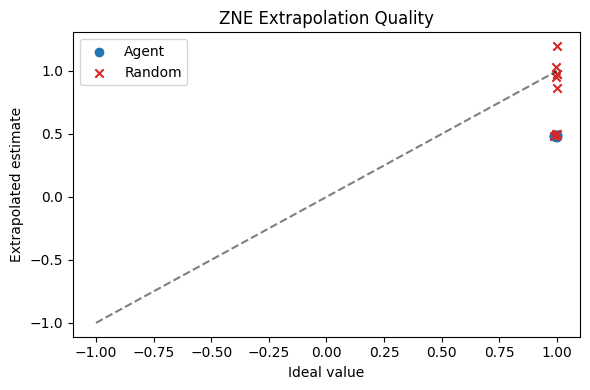


Sample episodes:
ideal=0.9891, est=0.4802, λs=[3.0, 3.0, 3.0], vals=[0.956 0.937 0.987]
ideal=0.9969, est=0.4940, λs=[3.0, 3.0, 3.0], vals=[1.    0.988 0.976]
ideal=0.9933, est=0.4854, λs=[3.0, 3.0, 3.0], vals=[1.    0.981 0.932]
ideal=1.0000, est=0.4738, λs=[3.0, 3.0, 3.0], vals=[0.968 0.94  0.935]
ideal=0.9883, est=0.4854, λs=[3.0, 3.0, 3.0], vals=[0.951 0.991 0.97 ]


In [21]:

#  Evaluation of trained PPO agent for ZNE parameter selection
#
import numpy as np
import matplotlib.pyplot as plt
import torch

def evaluate_agent(agent, env_gen, episodes=20, compare_random=True):
    """
    Evaluate PPO agent vs random baseline on ZNE environment.

    Returns:
        stats_agent: list of dicts from env info for trained agent
        stats_random: same, for random actions
    """
    def run_policy(policy_fn, episodes):
        stats = []
        for ep in range(episodes):
            env = env_gen()
            obs = env.reset()

            # Stage 1: choose extrapolator (0=Richardson, 1=Poly)
            a, *_ = policy_fn(obs, env.E)
            obs, _, done, info = env.step(a)

            # Stage 2: choose lambda folds
            for _ in range(env.max_folds + 1):
                a, *_ = policy_fn(obs, env.ACTIONS_PER_STEP)
                obs, r, done, info = env.step(a)
                if done:
                    stats.append(info)
                    break
            else:
                # Force stop if max steps reached
                obs, r, done, info = env.step(env.ACTIONS_PER_STEP - 1)
                stats.append(info)
        return stats

    # --- Run agent policy ---
    def agent_policy(obs, action_dim):
        a, logp, ent, probs, feat = agent.select_action(obs, action_dim)
        return a, logp, ent, probs, feat

    stats_agent = run_policy(agent_policy, episodes)

    # --- Optional random baseline ---
    stats_random = []
    if compare_random:
        def random_policy(obs, action_dim):
            a = np.random.randint(0, action_dim)
            return a, None, None, None, None
        stats_random = run_policy(random_policy, episodes)

    # --- Compute summary metrics ---
    def summarize(stats, label="Agent"):
        if not stats:
            return {}
        ideals = np.array([s["ideal"] for s in stats])
        ests = np.array([s["est"] for s in stats])
        errors = (ests - ideals) ** 2
        mean_err = np.mean(errors)
        mean_abs = np.mean(np.abs(ests - ideals))
        mean_lams = np.mean([len(s["lambdas"]) for s in stats])
        print(f"{label}: MSE={mean_err:.5f}, MAE={mean_abs:.5f}, Avg λ count={mean_lams:.2f}")
        return {"mse": mean_err, "mae": mean_abs, "lams": mean_lams}

    print("=== Evaluation Results ===")
    res_agent = summarize(stats_agent, "Trained Agent")
    if compare_random:
        res_random = summarize(stats_random, "Random Policy")

        # Relative improvement
        if res_random and res_agent:
            imp = 100 * (1 - res_agent["mse"] / (res_random["mse"] + 1e-12))
            print(f"Relative improvement in MSE vs random: {imp:.1f}%")

    # --- t ---
    plt.figure(figsize=(6,4))
    plt.scatter(
        [s["ideal"] for s in stats_agent],
        [s["est"] for s in stats_agent],
        label="Agent", color="tab:blue", marker="o"
    )
    if compare_random:
        plt.scatter(
            [s["ideal"] for s in stats_random],
            [s["est"] for s in stats_random],
            label="Random", color="tab:red", marker="x"
        )
    plt.plot([-1, 1], [-1, 1], "k--", alpha=0.5)
    plt.xlabel("Ideal value")
    plt.ylabel("Extrapolated estimate")
    plt.title("ZNE Extrapolation Quality")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Print example episodes ---
    print("\nSample episodes:")
    for s in stats_agent[:5]:
        print(f"ideal={s['ideal']:.4f}, est={s['est']:.4f}, λs={s['lambdas']}, vals={np.round(s['vals'],3)}")

    return stats_agent, stats_random


# Example evaluation after training
stats_agent, stats_random = evaluate_agent(agent, env_generator_random, episodes=10)
